# USING ``SISOClosedLoopDesigner``

This notebook contains a case study of using SISOClosedLoopDesigner


In [1]:
import controlSBML as ctl
from controlSBML import constants as cn

import control
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
ctl.__version__

'1.0.11'

# Models

## Linear

In [2]:
LINEAR_MDL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 2
k3 = 3
"""

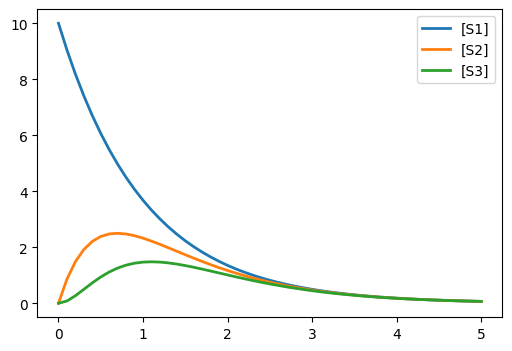

In [3]:
LINEAR_CTLSB = ctl.ControlSBML(LINEAR_MDL, input_names=["S1"], output_names=["S3"])
LINEAR_BLDR = LINEAR_CTLSB.makeSISOTransferFunctionBuilder()
LINEAR_CTLSB.roadrunner.simulate()
LINEAR_CTLSB.roadrunner.plot()

## Wolf

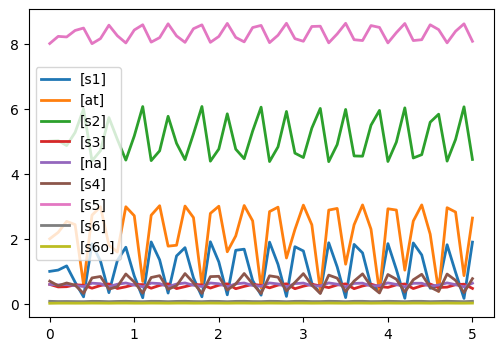

In [4]:
WOLF_CTLSB = ctl.ControlSBML(cn.WOLF_URL, input_names=["at"], output_names=["s6"])
WOLF_BLDR = WOLF_CTLSB.makeMIMOTransferFunctionBuilder()
WOLF_CTLSB.roadrunner.simulate()
WOLF_CTLSB.roadrunner.plot()

# System Identification

## Linear Model

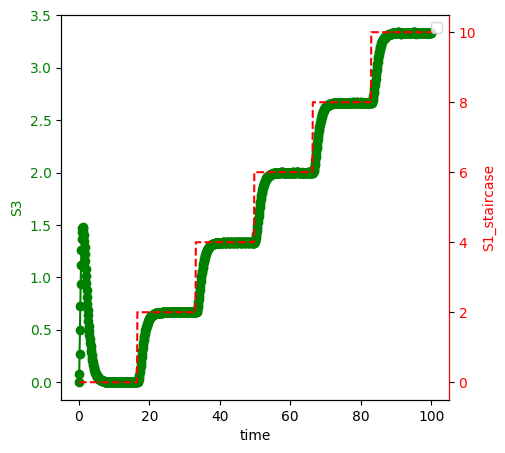

In [5]:
LINEAR_STAIRCASE = ctl.Staircase(initial_value=0, final_value=10, num_step=5)
response_ts = LINEAR_BLDR.makeStaircaseResponse(staircase=LINEAR_STAIRCASE, end_time=100)
_ = LINEAR_BLDR.plotStaircaseResponse(response_ts, figsize=(5,5))

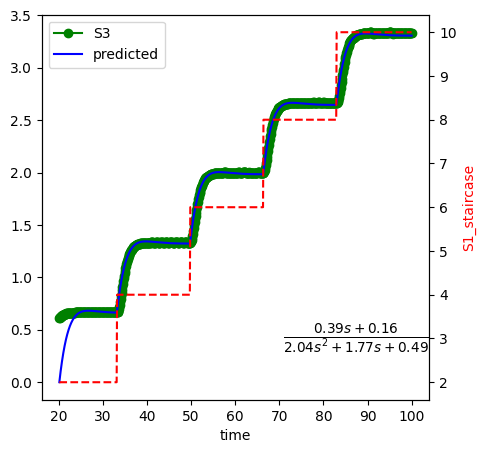

In [6]:
fitter_result = LINEAR_BLDR.fitTransferFunction(num_numerator=2, num_denominator=3, 
                                                      staircase=LINEAR_STAIRCASE, fit_start_time=20,
                                                start_time=0, end_time=100)
_ = LINEAR_BLDR.plotFitTransferFunction(fitter_result, figsize=(5,5))

## Wolf Model

In [7]:
if False:
    WOLF_STAIRCASE = ctl.Staircase(initial_value=0, final_value=100, num_step=5)
    response_ts = WOLF_BLDR.makeStaircaseResponse(staircase=WOLF_STAIRCASE, end_time=100)
    WOLF_BLDR.plotStaircaseResponse(response_ts)

# Testbed Construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

In [8]:
siso = ctl.SISOClosedLoopSystem(LINEAR_CTLSB)
siso.makePIDClosedLoopSystem(kp=0.5, ki=0.2, is_nonnegative_output=True, closed_loop_outputs=["S1", "S3"])

In [9]:
end_time =50
result_ts = siso.makeStepResponse(start_time=0, end_time=end_time, step_size=5)

Text(0, 0.5, 'S3')

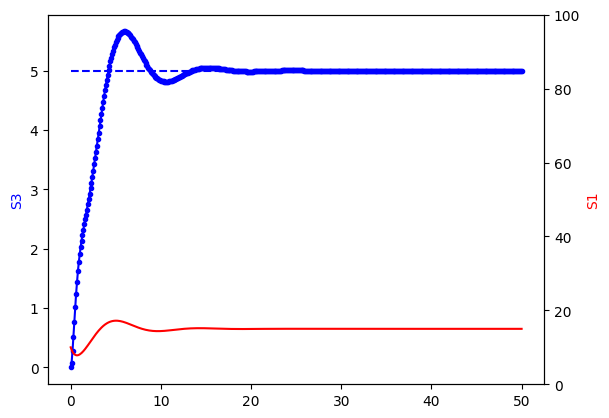

In [10]:
df = result_ts.copy()
times = np.array(df.index)/1000
plt.plot(times, df["S3"], color="blue", marker=".")
ax = plt.gca()
ax.plot(times, result_ts["reference"], linestyle="--", color = "blue")
ax2 = ax.twinx()
ax2.plot(times, result_ts["S1"], color="red")
ax2.set_ylim([0, 100])
ax2.set_ylabel("S1", color="red")
ax.set_ylabel("S3", color="blue")
#_ = ax.set_ylim([0, 5000])

# Closed Loop Design and Evaluation

In [11]:
designer = ctl.SISOClosedLoopDesigner(fitter_result.transfer_function)

In [12]:
designer.design(kp=True, ki=True)
designer.get()

{'kp': 999.8491091201836, 'ki': 507.89795930213086}

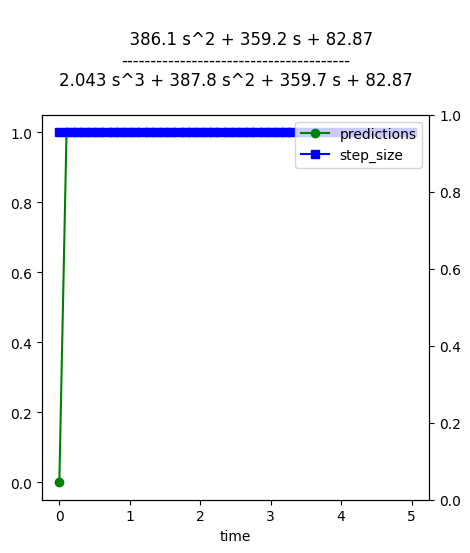

In [13]:
designer.plot(figsize=(5,5))

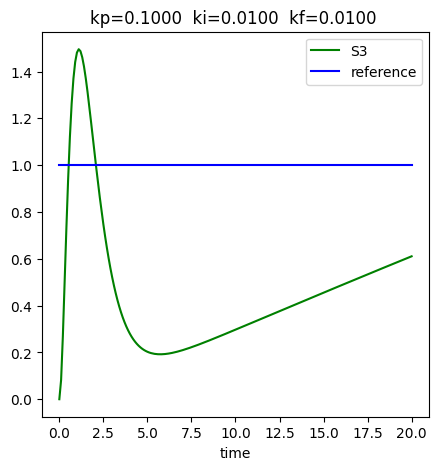

In [18]:
designer.set(kp=0.1, ki=0.01, kf=1e4)
times = [0, 20]
sys = designer.evaluateNonlinearIOSystemClosedLoop(LINEAR_CTLSB, times=times)

Is kf doing anything?